In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from sklearn.model_selection import train_test_split

## Use Pandas to create a dataframe

In [2]:
URL = 'https://storage.googleapis.com/applied-dl/heart.csv'
dataframe = pd.read_csv(URL)
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


## Split the dataframe into train, validation, and test

In [3]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

## Create a input pipeline using tf.data

In [4]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((dataframe.to_dict('list'), labels))
    if shuffle:
        ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [5]:
BATCH_SIZE = 5
train_ds = df_to_dataset(train, True, BATCH_SIZE)
val_ds = df_to_dataset(val, False, BATCH_SIZE)
test_ds = df_to_dataset(test, False, BATCH_SIZE)

## Understanding the input pipeline

In [6]:
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of ages:', feature_batch['age'])
    print('A batch of targets:', label_batch )

Every feature: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
A batch of ages: tf.Tensor([60 45 64 45 55], shape=(5,), dtype=int32)
A batch of targets: tf.Tensor([0 0 0 0 1], shape=(5,), dtype=int64)


## Demostrate several types of feature column

In [7]:
example_batch = next(iter(train_ds))[0]

In [8]:
# A utility method to create a feature column and to transform a batch of data
def demo(feature_column):
    feature_layer = tf.keras.layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch).numpy())

### Numeric columns

In [9]:
age = tf.feature_column.numeric_column('age')
demo(age)

[[60.]
 [45.]
 [64.]
 [45.]
 [55.]]


### Bucketized columns

In [10]:
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
demo(age_buckets)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


### Categorical columns

In [11]:
# `categorical_column` only converts string to index integer.
# `indicator_column` converts index integer to one/multi-hot encoding.
thal = tf.feature_column.categorical_column_with_vocabulary_list('thal', ['fixed', 'normal', 'reversible'])

thal_one_hot = tf.feature_column.indicator_column(thal)
demo(thal_one_hot)

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


### Embedding columns

In [17]:
thal_embedding = tf.feature_column.embedding_column(categorical_column=thal, dimension=8)
demo(thal_embedding)

[[ 0.37034944 -0.65990096 -0.12113193 -0.2881702  -0.14761657  0.16045214
   0.11549598 -0.32964462]
 [-0.07298197  0.33708128 -0.37177044 -0.5021354  -0.234732    0.18532518
  -0.1659273  -0.51153517]
 [-0.07298197  0.33708128 -0.37177044 -0.5021354  -0.234732    0.18532518
  -0.1659273  -0.51153517]
 [-0.07298197  0.33708128 -0.37177044 -0.5021354  -0.234732    0.18532518
  -0.1659273  -0.51153517]
 [ 0.37034944 -0.65990096 -0.12113193 -0.2881702  -0.14761657  0.16045214
   0.11549598 -0.32964462]]


### Hashed feature columns

In [19]:
thal_hashed = tf.feature_column.categorical_column_with_hash_bucket('thal', hash_bucket_size=10)
demo(tf.feature_column.indicator_column(thal_hashed))

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


### Crossed feature columns

In [21]:
crossed_feature = tf.feature_column.crossed_column([age_buckets, thal], hash_bucket_size=10)
demo(tf.feature_column.indicator_column(crossed_feature))

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


## Choose which feature columns to use

In [24]:
feature_columns = []

# numeric columns
for header in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'ca']:
    feature_columns.append(tf.feature_column.numeric_column(header))
    
# bucketized columns
age_buckets = tf.feature_column.bucketized_column(tf.feature_column.numeric_column('age'),
                                                  boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

# indicator columns
thal = tf.feature_column.categorical_column_with_vocabulary_list('thal', ['fixed', 'normal', 'reversible'])
thal_one_hot = tf.feature_column.indicator_column(thal)
feature_columns.append(thal_one_hot)

# embedding columns
thal_embedding = tf.feature_column.embedding_column(thal, dimension=8)
feature_columns.append(thal_embedding)

# crossed columns
crossed_feature = tf.feature_column.crossed_column([age_buckets, thal], hash_bucket_size=1000)
crossed_feature = tf.feature_column.indicator_column(crossed_feature)
feature_columns.append(crossed_feature)

### Create a feature layer

In [26]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [28]:
BATCH_SIZE = 32
train_ds = df_to_dataset(train, True, BATCH_SIZE)
val_ds = df_to_dataset(val, False, BATCH_SIZE)
test_ds = df_to_dataset(test, False, BATCH_SIZE)

## Create, compile, and train the model

In [29]:
model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [33]:
model.compile(optimizer='Adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [35]:
model.fit(train_ds, epochs=50, validation_data=val_ds, verbose=0)

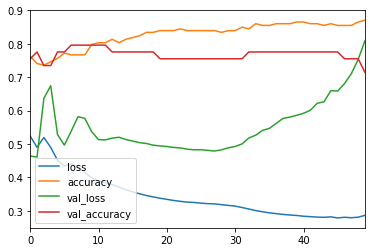

In [39]:
pd.DataFrame(model.history.history).plot()